### Подключение библиотек

In [17]:
import pandas
import catboost as cat
from catboost import CatBoostRegressor, cv, Pool, CatBoostClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import silhouette_score
from sklearn.metrics import r2_score, recall_score, mean_absolute_percentage_error
import matplotlib.pyplot as plot

### Чтение файла

In [18]:
dataframe = pandas.read_csv('train_dataset_train.csv', skiprows = range(1, 300000), nrows = 100000)
dataframe

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label
0,300000,4C3C0517A533FA754CEB8823E9481079,Социальная карта москвича,248,Алексеевская,6002,Алексеевская,6,Калужско-Рижская,2022-09-13 10:28:55,413.983333,8007
1,300001,EDD15E12C38D3A3651D031E2A94176D2,ВЕСБ МОСКВА (7мин),386,Нагорная,9010,Нагорная,9,Серпуховско-Тимирязевская,2022-09-13 10:28:55,486.883333,1019
2,300002,E6B8B6D8206FB973211E20A324397A87,ББК,88,Автозаводская ( Южный ),2001,Автозаводская,2,Замоскворецкая,2022-09-13 10:28:55,667.300000,7015
3,300003,514AFFA5070D6F5A05D1BD13C04AC425,СК студента 90 дней,84,Коломенская ( Северный ),2011,Коломенская,2,Замоскворецкая,2022-09-13 10:28:56,458.233333,81001
4,300004,44AA27993CB4A082630FAACB5A54C4B6,90 дней,2163,Верхние Котлы МЦК,14007,Верхние Котлы,14,Московское центральное кольцо,2022-09-13 10:28:56,482.483333,4007
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,399995,63BB118D97017C43C48F51D2D9BB6648,30 дней ЕДИНЫЙ ТК,2199,Раменки(второй),81006,Раменки,81,Солнцевская,2022-09-14 08:02:30,769.500000,1008
99996,399996,FF02773E9751339CF90959B07076F1F0,Социальная карта москвича,24,Черкизовская ( Южный ),1020,Черкизовская,1,Сокольническая,2022-09-14 08:02:30,550.833333,10003
99997,399997,9632B311D09F89C752B044EA7D7691C4,30 дней,410,Печатники,10016,Печатники,10,Люблинско-Дмитровская,2022-09-14 08:02:30,723.000000,6005
99998,399998,7742ED39FCB0D2A9175BDCC52B80F322,КОШЕЛЕК,275,Новые Черёмушки (Северный),6013,Новые Черёмушки,6,Калужско-Рижская,2022-09-14 08:02:30,648.733333,1002


### Посмотрим на количество уникальных значений

In [19]:
dataframe.nunique()

id                100000
ticket_id          98053
ticket_type_nm        55
entrance_id          423
entrance_nm          423
station_id           274
station_nm           243
line_id               16
line_nm               16
pass_dttm          32233
time_to_under      43988
label                274
dtype: int64

### Построим гистограммы столбцов для предсказаний

array([[<AxesSubplot:title={'center':'label'}>]], dtype=object)

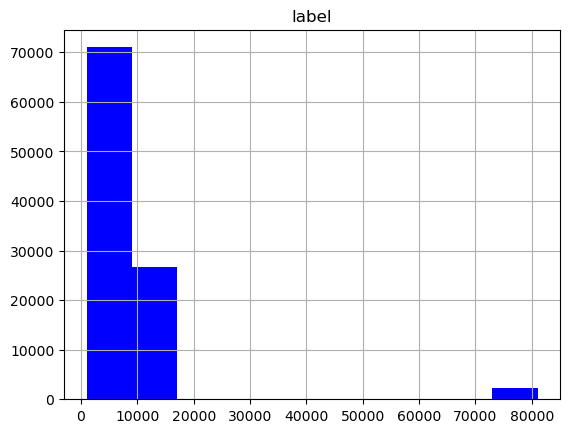

In [20]:
dataframe.hist(column = 'label', color = 'blue')

array([[<AxesSubplot:title={'center':'time_to_under'}>]], dtype=object)

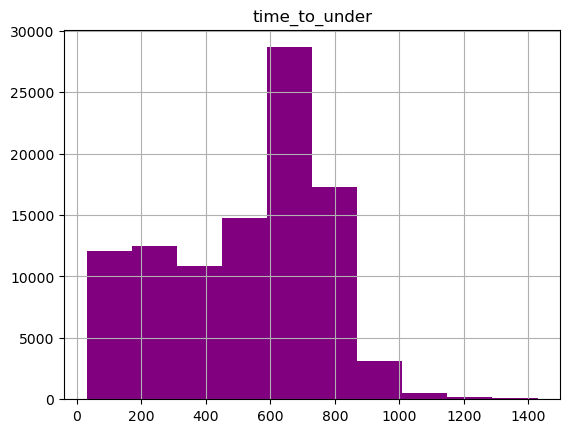

In [21]:
dataframe.hist(column = 'time_to_under', color = 'purple')

### Задача классификации
Удалим лишние столбцы, а именно id, ticket_id, entrance_nm, station_nm, line_id, pass_dttm, time_to_under

In [22]:
dataframe.drop(columns = ['id','ticket_id','station_nm','line_id','pass_dttm','time_to_under','entrance_nm'], inplace = True)
dataframe.head(6)

,ticket_type_nm,entrance_id,station_id,line_nm,label
0,Социальная карта москвича,248,6002,Калужско-Рижская,8007
1,ВЕСБ МОСКВА (7мин),386,9010,Серпуховско-Тимирязевская,1019
2,ББК,88,2001,Замоскворецкая,7015
3,СК студента 90 дней,84,2011,Замоскворецкая,81001
4,90 дней,2163,14007,Московское центральное кольцо,4007
5,КОШЕЛЕК,240,6018,Калужско-Рижская,7004


### Преобразуем столбцы в категориальные значения

In [23]:
columns = ['ticket_type_nm', 'entrance_id', 'station_id','line_nm']
for i in columns:
    dataframe[i] = dataframe[i].astype('category').cat.codes
    
dataframe.head(6)

,ticket_type_nm,entrance_id,station_id,line_nm,label
0,52,128,93,5,8007
1,31,210,154,11,1019
2,24,41,24,3,7015
3,47,38,34,3,81001
4,16,327,229,9,4007
5,34,123,109,5,7004


### Модель CatBoost
- learning_rate - скорость обучения, которая определяет насколько быстро или медленно модель будет учиться.
- l2_leaf_reg - коэффициент при члене регуляризации L2 функции потерь
- depth - глубина дерева
- iterations - максимальное количество построенных деревьев

train_test_split - разбивает датасет на данные для обучения и тестирования; GridSearchCV находит наилучшие параметры, путем обычного перебора

In [24]:
train, test, y_train, y_test = train_test_split(dataframe.drop(["label"], axis = 1), dataframe["label"],
                                                random_state = 10, test_size = 0.3)

parametrs = {'learning_rate': [0.03],
            'l2_leaf_reg': [3],
            'depth': [3, 6, 9],
            'iterations': [10]}

cat = cat.CatBoostClassifier()
cat_model = GridSearchCV(cat, parametrs, scoring = 'roc_auc', cv = 3)
cat_model.fit(train, y_train)

C:\Users\katep\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:676: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


0:	learn: 5.5773696	total: 2.17s	remaining: 19.5s
1:	learn: 5.5528789	total: 4.28s	remaining: 17.1s
2:	learn: 5.5262403	total: 6.31s	remaining: 14.7s
3:	learn: 5.5043311	total: 8.4s	remaining: 12.6s
4:	learn: 5.4853664	total: 10.4s	remaining: 10.4s
5:	learn: 5.4678102	total: 12.5s	remaining: 8.36s
6:	learn: 5.4505502	total: 14.6s	remaining: 6.26s
7:	learn: 5.4353533	total: 16.7s	remaining: 4.19s
8:	learn: 5.4199844	total: 18.8s	remaining: 2.09s
9:	learn: 5.4070106	total: 20.9s	remaining: 0us


C:\Users\katep\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\katep\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\katep\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\katep\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 5.5843912	total: 2.23s	remaining: 20s
1:	learn: 5.5597090	total: 4.37s	remaining: 17.5s
2:	learn: 5.5327542	total: 6.46s	remaining: 15.1s
3:	learn: 5.5105863	total: 8.53s	remaining: 12.8s
4:	learn: 5.4913316	total: 10.7s	remaining: 10.7s
5:	learn: 5.4730708	total: 12.8s	remaining: 8.52s
6:	learn: 5.4552328	total: 14.9s	remaining: 6.37s
7:	learn: 5.4395933	total: 17s	remaining: 4.24s
8:	learn: 5.4242117	total: 19.1s	remaining: 2.12s
9:	learn: 5.4102213	total: 21.1s	remaining: 0us


C:\Users\katep\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\katep\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\katep\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\katep\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 5.5809225	total: 2.29s	remaining: 20.6s
1:	learn: 5.5558286	total: 4.32s	remaining: 17.3s
2:	learn: 5.5292367	total: 6.39s	remaining: 14.9s
3:	learn: 5.5074254	total: 8.47s	remaining: 12.7s
4:	learn: 5.4883390	total: 10.5s	remaining: 10.5s
5:	learn: 5.4700946	total: 12.6s	remaining: 8.39s
6:	learn: 5.4536885	total: 14.6s	remaining: 6.27s
7:	learn: 5.4383429	total: 16.7s	remaining: 4.18s
8:	learn: 5.4228018	total: 18.7s	remaining: 2.08s
9:	learn: 5.4096838	total: 20.8s	remaining: 0us


C:\Users\katep\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\katep\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\katep\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\katep\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 5.5751566	total: 2.63s	remaining: 23.6s
1:	learn: 5.5411873	total: 6.24s	remaining: 25s
2:	learn: 5.5126835	total: 9.66s	remaining: 22.5s
3:	learn: 5.4874355	total: 13s	remaining: 19.4s
4:	learn: 5.4623876	total: 16.4s	remaining: 16.4s
5:	learn: 5.4404916	total: 19.7s	remaining: 13.2s
6:	learn: 5.4198806	total: 23.1s	remaining: 9.91s
7:	learn: 5.3992936	total: 26.7s	remaining: 6.67s
8:	learn: 5.3821211	total: 30.1s	remaining: 3.35s
9:	learn: 5.3645195	total: 33.3s	remaining: 0us


C:\Users\katep\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\katep\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\katep\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\katep\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 5.5822036	total: 2.73s	remaining: 24.6s
1:	learn: 5.5476047	total: 6.05s	remaining: 24.2s
2:	learn: 5.5191471	total: 9.58s	remaining: 22.4s
3:	learn: 5.4933405	total: 12.9s	remaining: 19.3s
4:	learn: 5.4703139	total: 16.3s	remaining: 16.3s
5:	learn: 5.4481422	total: 19.7s	remaining: 13.1s
6:	learn: 5.4271518	total: 23.1s	remaining: 9.91s
7:	learn: 5.4059572	total: 26.5s	remaining: 6.62s
8:	learn: 5.3889740	total: 29.9s	remaining: 3.32s
9:	learn: 5.3709133	total: 33.2s	remaining: 0us


C:\Users\katep\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\katep\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\katep\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\katep\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 5.5786027	total: 2.73s	remaining: 24.6s
1:	learn: 5.5442452	total: 6.19s	remaining: 24.8s
2:	learn: 5.5149940	total: 9.62s	remaining: 22.5s
3:	learn: 5.4894623	total: 13.1s	remaining: 19.6s
4:	learn: 5.4647598	total: 16.3s	remaining: 16.3s
5:	learn: 5.4427861	total: 19.6s	remaining: 13.1s
6:	learn: 5.4220204	total: 23.1s	remaining: 9.88s
7:	learn: 5.4012324	total: 26.4s	remaining: 6.59s
8:	learn: 5.3838746	total: 29.8s	remaining: 3.31s
9:	learn: 5.3662842	total: 33.1s	remaining: 0us


C:\Users\katep\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\katep\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\katep\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\katep\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 5.5751566	total: 2.68s	remaining: 24.1s
1:	learn: 5.5440168	total: 32s	remaining: 2m 7s
2:	learn: 5.5155103	total: 1m 10s	remaining: 2m 43s
3:	learn: 5.4866193	total: 1m 31s	remaining: 2m 16s
4:	learn: 5.4611821	total: 2m 3s	remaining: 2m 3s
5:	learn: 5.4367744	total: 2m 27s	remaining: 1m 38s
6:	learn: 5.4133697	total: 3m 5s	remaining: 1m 19s
7:	learn: 5.3942531	total: 3m 51s	remaining: 57.9s
8:	learn: 5.3735601	total: 4m 11s	remaining: 27.9s
9:	learn: 5.3560127	total: 4m 42s	remaining: 0us


C:\Users\katep\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\katep\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\katep\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\katep\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 5.5822036	total: 1.5s	remaining: 13.5s
1:	learn: 5.5507109	total: 23.7s	remaining: 1m 34s
2:	learn: 5.5210255	total: 55.6s	remaining: 2m 9s
3:	learn: 5.4933427	total: 1m 18s	remaining: 1m 57s
4:	learn: 5.4646036	total: 1m 56s	remaining: 1m 56s
5:	learn: 5.4400000	total: 2m 25s	remaining: 1m 37s
6:	learn: 5.4185817	total: 2m 59s	remaining: 1m 17s
7:	learn: 5.3968757	total: 3m 40s	remaining: 55.1s
8:	learn: 5.3751738	total: 4m 35s	remaining: 30.6s
9:	learn: 5.3582895	total: 5m 3s	remaining: 0us


C:\Users\katep\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\katep\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\katep\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\katep\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(


0:	learn: 5.5786027	total: 1.49s	remaining: 13.4s
1:	learn: 5.5469021	total: 27.4s	remaining: 1m 49s
2:	learn: 5.5178613	total: 1m 6s	remaining: 2m 34s
3:	learn: 5.4903849	total: 1m 31s	remaining: 2m 17s
4:	learn: 5.4619765	total: 1m 57s	remaining: 1m 57s
5:	learn: 5.4374943	total: 2m 23s	remaining: 1m 35s
6:	learn: 5.4139619	total: 3m 4s	remaining: 1m 19s
7:	learn: 5.3944168	total: 3m 33s	remaining: 53.3s
8:	learn: 5.3755890	total: 3m 43s	remaining: 24.8s
9:	learn: 5.3575996	total: 4m 27s	remaining: 0us


C:\Users\katep\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:770: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\katep\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 761, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\katep\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 216, in __call__
    return self._score(
  File "C:\Users\katep\anaconda3\lib\site-packages\sklearn\metrics\_scorer.py", line 349, in _score
    raise ValueError("{0} format is not supported".format(y_type))
ValueError: multiclass format is not supported

  warnings.warn(
C:\Users\katep\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan]
  warnings.warn(


0:	learn: 5.5831885	total: 2.02s	remaining: 18.2s
1:	learn: 5.5551822	total: 4.13s	remaining: 16.5s
2:	learn: 5.5280357	total: 6.09s	remaining: 14.2s
3:	learn: 5.5056344	total: 8.03s	remaining: 12.1s
4:	learn: 5.4836039	total: 9.87s	remaining: 9.87s
5:	learn: 5.4652867	total: 11.7s	remaining: 7.8s
6:	learn: 5.4471406	total: 13.6s	remaining: 5.83s
7:	learn: 5.4317123	total: 15.6s	remaining: 3.91s
8:	learn: 5.4163147	total: 17.6s	remaining: 1.96s
9:	learn: 5.4034908	total: 19.4s	remaining: 0us


GridSearchCV(cv=3,
             estimator=<catboost.core.CatBoostClassifier object at 0x000002BB810A8850>,
             param_grid={'depth': [3, 6, 9], 'iterations': [10],
                         'l2_leaf_reg': [3], 'learning_rate': [0.03]},
             scoring='roc_auc')

In [25]:
predict = cat_model.predict(test)
predict

array([[11008],
       [ 6008],
       [ 3002],
       ...,
       [ 1022],
       [ 1022],
       [ 3002]], dtype=int64)

### Теперь посмотрим на наилучшие параметры

In [26]:
cat_model.best_estimator_
cat_model.best_score_
cat_model.best_params_

{'depth': 3, 'iterations': 10, 'l2_leaf_reg': 3, 'learning_rate': 0.03}

In [30]:
clf = CatBoostClassifier(depth = 3, iterations = 2000, l2_leaf_reg = 3, learning_rate = 0.03)
clf.fit(train, y_train)

0:	learn: 5.5831885	total: 1.62s	remaining: 53m 53s
1:	learn: 5.5551822	total: 3.07s	remaining: 51m 5s
2:	learn: 5.5280357	total: 4.59s	remaining: 50m 57s
3:	learn: 5.5056344	total: 6.1s	remaining: 50m 45s
4:	learn: 5.4836039	total: 7.66s	remaining: 50m 54s
5:	learn: 5.4652867	total: 9.19s	remaining: 50m 53s
6:	learn: 5.4471406	total: 10.7s	remaining: 50m 35s
7:	learn: 5.4317123	total: 12.2s	remaining: 50m 46s
8:	learn: 5.4163147	total: 13.9s	remaining: 51m 9s
9:	learn: 5.4034908	total: 15.4s	remaining: 50m 59s
10:	learn: 5.3884174	total: 16.7s	remaining: 50m 24s
11:	learn: 5.3747818	total: 18.2s	remaining: 50m 16s
12:	learn: 5.3637494	total: 19.7s	remaining: 50m 7s
13:	learn: 5.3498007	total: 21.1s	remaining: 49m 58s
14:	learn: 5.3377179	total: 22.6s	remaining: 49m 44s
15:	learn: 5.3300986	total: 24.1s	remaining: 49m 53s
16:	learn: 5.3181225	total: 25.6s	remaining: 49m 45s
17:	learn: 5.3081573	total: 27.1s	remaining: 49m 40s
18:	learn: 5.2982660	total: 28.5s	remaining: 49m 27s
19:	lea

154:	learn: 4.9852979	total: 4m 54s	remaining: 58m 21s
155:	learn: 4.9848318	total: 4m 56s	remaining: 58m 19s
156:	learn: 4.9845108	total: 4m 57s	remaining: 58m 17s
157:	learn: 4.9836540	total: 4m 59s	remaining: 58m 15s
158:	learn: 4.9828790	total: 5m 1s	remaining: 58m 12s
159:	learn: 4.9819697	total: 5m 3s	remaining: 58m 10s
160:	learn: 4.9814902	total: 5m 5s	remaining: 58m 9s
161:	learn: 4.9803785	total: 5m 7s	remaining: 58m 8s
162:	learn: 4.9795524	total: 5m 9s	remaining: 58m 6s
163:	learn: 4.9789890	total: 5m 11s	remaining: 58m 5s
164:	learn: 4.9783336	total: 5m 13s	remaining: 58m 4s
165:	learn: 4.9777923	total: 5m 15s	remaining: 58m 5s
166:	learn: 4.9770252	total: 5m 17s	remaining: 58m 4s
167:	learn: 4.9762228	total: 5m 19s	remaining: 58m 3s
168:	learn: 4.9757276	total: 5m 21s	remaining: 58m 2s
169:	learn: 4.9750359	total: 5m 23s	remaining: 58m 1s
170:	learn: 4.9742215	total: 5m 25s	remaining: 58m
171:	learn: 4.9736786	total: 5m 27s	remaining: 57m 59s
172:	learn: 4.9727581	total: 

305:	learn: 4.9094847	total: 9m 48s	remaining: 54m 17s
306:	learn: 4.9092326	total: 9m 50s	remaining: 54m 15s
307:	learn: 4.9086158	total: 9m 52s	remaining: 54m 13s
308:	learn: 4.9081105	total: 9m 53s	remaining: 54m 10s
309:	learn: 4.9077018	total: 9m 55s	remaining: 54m 8s
310:	learn: 4.9073962	total: 9m 57s	remaining: 54m 5s
311:	learn: 4.9070476	total: 9m 59s	remaining: 54m 4s
312:	learn: 4.9067181	total: 10m 1s	remaining: 54m 1s
313:	learn: 4.9063545	total: 10m 3s	remaining: 53m 59s
314:	learn: 4.9060682	total: 10m 5s	remaining: 53m 57s
315:	learn: 4.9057289	total: 10m 7s	remaining: 53m 55s
316:	learn: 4.9053624	total: 10m 9s	remaining: 53m 53s
317:	learn: 4.9049700	total: 10m 10s	remaining: 53m 51s
318:	learn: 4.9047648	total: 10m 12s	remaining: 53m 49s
319:	learn: 4.9043542	total: 10m 14s	remaining: 53m 47s
320:	learn: 4.9038786	total: 10m 16s	remaining: 53m 46s
321:	learn: 4.9036330	total: 10m 18s	remaining: 53m 44s
322:	learn: 4.9032247	total: 10m 20s	remaining: 53m 42s
323:	lea

453:	learn: 4.8724677	total: 14m 44s	remaining: 50m 13s
454:	learn: 4.8723464	total: 14m 46s	remaining: 50m 11s
455:	learn: 4.8721207	total: 14m 48s	remaining: 50m 9s
456:	learn: 4.8719148	total: 14m 50s	remaining: 50m 7s
457:	learn: 4.8717442	total: 14m 52s	remaining: 50m 5s
458:	learn: 4.8715614	total: 14m 54s	remaining: 50m 3s
459:	learn: 4.8713585	total: 14m 56s	remaining: 50m 1s
460:	learn: 4.8711534	total: 14m 58s	remaining: 49m 59s
461:	learn: 4.8709454	total: 15m	remaining: 49m 57s
462:	learn: 4.8708244	total: 15m 2s	remaining: 49m 55s
463:	learn: 4.8705187	total: 15m 4s	remaining: 49m 53s
464:	learn: 4.8703444	total: 15m 6s	remaining: 49m 51s
465:	learn: 4.8701440	total: 15m 7s	remaining: 49m 48s
466:	learn: 4.8699318	total: 15m 9s	remaining: 49m 46s
467:	learn: 4.8695667	total: 15m 11s	remaining: 49m 44s
468:	learn: 4.8693909	total: 15m 13s	remaining: 49m 42s
469:	learn: 4.8691101	total: 15m 15s	remaining: 49m 40s
470:	learn: 4.8688875	total: 15m 17s	remaining: 49m 38s
471:	l

601:	learn: 4.8492483	total: 19m 33s	remaining: 45m 25s
602:	learn: 4.8490078	total: 19m 35s	remaining: 45m 23s
603:	learn: 4.8488633	total: 19m 37s	remaining: 45m 22s
604:	learn: 4.8487657	total: 19m 39s	remaining: 45m 20s
605:	learn: 4.8485980	total: 19m 41s	remaining: 45m 18s
606:	learn: 4.8483813	total: 19m 43s	remaining: 45m 16s
607:	learn: 4.8481242	total: 19m 45s	remaining: 45m 13s
608:	learn: 4.8480102	total: 19m 47s	remaining: 45m 11s
609:	learn: 4.8479192	total: 19m 49s	remaining: 45m 9s
610:	learn: 4.8477571	total: 19m 50s	remaining: 45m 7s
611:	learn: 4.8475888	total: 19m 52s	remaining: 45m 5s
612:	learn: 4.8473661	total: 19m 54s	remaining: 45m 2s
613:	learn: 4.8472588	total: 19m 56s	remaining: 45m
614:	learn: 4.8471467	total: 19m 58s	remaining: 44m 58s
615:	learn: 4.8469505	total: 20m	remaining: 44m 56s
616:	learn: 4.8468324	total: 20m 1s	remaining: 44m 54s
617:	learn: 4.8467324	total: 20m 3s	remaining: 44m 51s
618:	learn: 4.8466173	total: 20m 5s	remaining: 44m 49s
619:	le

749:	learn: 4.8290990	total: 24m 10s	remaining: 40m 17s
750:	learn: 4.8290148	total: 24m 12s	remaining: 40m 15s
751:	learn: 4.8288883	total: 24m 14s	remaining: 40m 13s
752:	learn: 4.8288123	total: 24m 15s	remaining: 40m 11s
753:	learn: 4.8286589	total: 24m 17s	remaining: 40m 9s
754:	learn: 4.8285316	total: 24m 19s	remaining: 40m 7s
755:	learn: 4.8284701	total: 24m 21s	remaining: 40m 5s
756:	learn: 4.8283852	total: 24m 23s	remaining: 40m 3s
757:	learn: 4.8282526	total: 24m 25s	remaining: 40m 1s
758:	learn: 4.8281409	total: 24m 27s	remaining: 39m 59s
759:	learn: 4.8280142	total: 24m 29s	remaining: 39m 56s
760:	learn: 4.8279075	total: 24m 31s	remaining: 39m 55s
761:	learn: 4.8278739	total: 24m 32s	remaining: 39m 52s
762:	learn: 4.8277946	total: 24m 34s	remaining: 39m 50s
763:	learn: 4.8276722	total: 24m 36s	remaining: 39m 48s
764:	learn: 4.8275907	total: 24m 38s	remaining: 39m 46s
765:	learn: 4.8274779	total: 24m 40s	remaining: 39m 44s
766:	learn: 4.8273887	total: 24m 42s	remaining: 39m 4

897:	learn: 4.8129151	total: 28m 47s	remaining: 35m 19s
898:	learn: 4.8128033	total: 28m 48s	remaining: 35m 17s
899:	learn: 4.8127127	total: 28m 50s	remaining: 35m 15s
900:	learn: 4.8126593	total: 28m 52s	remaining: 35m 13s
901:	learn: 4.8125161	total: 28m 54s	remaining: 35m 11s
902:	learn: 4.8124253	total: 28m 56s	remaining: 35m 9s
903:	learn: 4.8123673	total: 28m 58s	remaining: 35m 7s
904:	learn: 4.8122811	total: 29m	remaining: 35m 5s
905:	learn: 4.8121486	total: 29m 1s	remaining: 35m 3s
906:	learn: 4.8120138	total: 29m 3s	remaining: 35m 1s
907:	learn: 4.8119316	total: 29m 5s	remaining: 34m 59s
908:	learn: 4.8118780	total: 29m 7s	remaining: 34m 57s
909:	learn: 4.8117362	total: 29m 9s	remaining: 34m 55s
910:	learn: 4.8116232	total: 29m 11s	remaining: 34m 54s
911:	learn: 4.8114818	total: 29m 13s	remaining: 34m 52s
912:	learn: 4.8112560	total: 29m 15s	remaining: 34m 50s
913:	learn: 4.8111114	total: 29m 17s	remaining: 34m 48s
914:	learn: 4.8108781	total: 29m 19s	remaining: 34m 46s
915:	l

1044:	learn: 4.7979604	total: 33m 36s	remaining: 30m 42s
1045:	learn: 4.7978751	total: 33m 38s	remaining: 30m 40s
1046:	learn: 4.7977932	total: 33m 40s	remaining: 30m 38s
1047:	learn: 4.7977247	total: 33m 42s	remaining: 30m 36s
1048:	learn: 4.7976574	total: 33m 43s	remaining: 30m 34s
1049:	learn: 4.7975919	total: 33m 45s	remaining: 30m 32s
1050:	learn: 4.7975040	total: 33m 47s	remaining: 30m 30s
1051:	learn: 4.7973712	total: 33m 49s	remaining: 30m 29s
1052:	learn: 4.7971525	total: 33m 51s	remaining: 30m 27s
1053:	learn: 4.7971211	total: 33m 53s	remaining: 30m 25s
1054:	learn: 4.7967243	total: 33m 55s	remaining: 30m 23s
1055:	learn: 4.7966435	total: 33m 57s	remaining: 30m 21s
1056:	learn: 4.7965019	total: 33m 59s	remaining: 30m 19s
1057:	learn: 4.7964372	total: 34m 1s	remaining: 30m 17s
1058:	learn: 4.7963660	total: 34m 3s	remaining: 30m 16s
1059:	learn: 4.7962378	total: 34m 5s	remaining: 30m 14s
1060:	learn: 4.7961635	total: 34m 7s	remaining: 30m 12s
1061:	learn: 4.7961251	total: 34m 9

1189:	learn: 4.7847819	total: 38m 50s	remaining: 26m 25s
1190:	learn: 4.7847368	total: 38m 52s	remaining: 26m 24s
1191:	learn: 4.7846491	total: 38m 54s	remaining: 26m 22s
1192:	learn: 4.7845951	total: 38m 57s	remaining: 26m 20s
1193:	learn: 4.7845258	total: 38m 59s	remaining: 26m 19s
1194:	learn: 4.7844115	total: 39m 2s	remaining: 26m 18s
1195:	learn: 4.7842944	total: 39m 5s	remaining: 26m 16s
1196:	learn: 4.7842472	total: 39m 7s	remaining: 26m 14s
1197:	learn: 4.7841885	total: 39m 10s	remaining: 26m 13s
1198:	learn: 4.7841282	total: 39m 12s	remaining: 26m 11s
1199:	learn: 4.7840845	total: 39m 14s	remaining: 26m 9s
1200:	learn: 4.7840152	total: 39m 17s	remaining: 26m 8s
1201:	learn: 4.7838856	total: 39m 20s	remaining: 26m 6s
1202:	learn: 4.7838317	total: 39m 22s	remaining: 26m 5s
1203:	learn: 4.7838037	total: 39m 25s	remaining: 26m 3s
1204:	learn: 4.7837261	total: 39m 27s	remaining: 26m 2s
1205:	learn: 4.7836377	total: 39m 30s	remaining: 26m
1206:	learn: 4.7835733	total: 39m 33s	remain

1334:	learn: 4.7726037	total: 44m 4s	remaining: 21m 57s
1335:	learn: 4.7725077	total: 44m 6s	remaining: 21m 55s
1336:	learn: 4.7724197	total: 44m 8s	remaining: 21m 53s
1337:	learn: 4.7722638	total: 44m 11s	remaining: 21m 51s
1338:	learn: 4.7721912	total: 44m 12s	remaining: 21m 49s
1339:	learn: 4.7721392	total: 44m 14s	remaining: 21m 47s
1340:	learn: 4.7720135	total: 44m 16s	remaining: 21m 45s
1341:	learn: 4.7719492	total: 44m 18s	remaining: 21m 43s
1342:	learn: 4.7718436	total: 44m 20s	remaining: 21m 41s
1343:	learn: 4.7718162	total: 44m 22s	remaining: 21m 39s
1344:	learn: 4.7717262	total: 44m 24s	remaining: 21m 37s
1345:	learn: 4.7716737	total: 44m 27s	remaining: 21m 35s
1346:	learn: 4.7716320	total: 44m 29s	remaining: 21m 34s
1347:	learn: 4.7715490	total: 44m 31s	remaining: 21m 32s
1348:	learn: 4.7714830	total: 44m 33s	remaining: 21m 30s
1349:	learn: 4.7714103	total: 44m 35s	remaining: 21m 28s
1350:	learn: 4.7713690	total: 44m 37s	remaining: 21m 26s
1351:	learn: 4.7712923	total: 44m 

1479:	learn: 4.7611166	total: 51m 27s	remaining: 18m 4s
1480:	learn: 4.7610243	total: 51m 31s	remaining: 18m 3s
1481:	learn: 4.7609827	total: 51m 35s	remaining: 18m 2s
1482:	learn: 4.7608915	total: 51m 39s	remaining: 18m
1483:	learn: 4.7608559	total: 51m 43s	remaining: 17m 59s
1484:	learn: 4.7607793	total: 51m 47s	remaining: 17m 57s
1485:	learn: 4.7607146	total: 51m 51s	remaining: 17m 56s
1486:	learn: 4.7606506	total: 51m 55s	remaining: 17m 54s
1487:	learn: 4.7605638	total: 51m 58s	remaining: 17m 53s
1488:	learn: 4.7604228	total: 52m 2s	remaining: 17m 51s
1489:	learn: 4.7603994	total: 52m 6s	remaining: 17m 50s
1490:	learn: 4.7603269	total: 52m 10s	remaining: 17m 48s
1491:	learn: 4.7602116	total: 52m 14s	remaining: 17m 47s
1492:	learn: 4.7601896	total: 52m 18s	remaining: 17m 45s
1493:	learn: 4.7601199	total: 52m 21s	remaining: 17m 44s
1494:	learn: 4.7600586	total: 52m 25s	remaining: 17m 42s
1495:	learn: 4.7599663	total: 52m 29s	remaining: 17m 41s
1496:	learn: 4.7599416	total: 52m 33s	re

1624:	learn: 4.7507680	total: 1h 45s	remaining: 14m 1s
1625:	learn: 4.7506849	total: 1h 49s	remaining: 13m 59s
1626:	learn: 4.7505875	total: 1h 53s	remaining: 13m 57s
1627:	learn: 4.7505336	total: 1h 57s	remaining: 13m 55s
1628:	learn: 4.7505090	total: 1h 1m	remaining: 13m 53s
1629:	learn: 4.7503792	total: 1h 1m 4s	remaining: 13m 51s
1630:	learn: 4.7503047	total: 1h 1m 8s	remaining: 13m 50s
1631:	learn: 4.7502416	total: 1h 1m 12s	remaining: 13m 48s
1632:	learn: 4.7501983	total: 1h 1m 16s	remaining: 13m 46s
1633:	learn: 4.7501243	total: 1h 1m 20s	remaining: 13m 44s
1634:	learn: 4.7500862	total: 1h 1m 23s	remaining: 13m 42s
1635:	learn: 4.7500484	total: 1h 1m 27s	remaining: 13m 40s
1636:	learn: 4.7499969	total: 1h 1m 31s	remaining: 13m 38s
1637:	learn: 4.7499788	total: 1h 1m 35s	remaining: 13m 36s
1638:	learn: 4.7498888	total: 1h 1m 39s	remaining: 13m 34s
1639:	learn: 4.7498319	total: 1h 1m 42s	remaining: 13m 32s
1640:	learn: 4.7497604	total: 1h 1m 45s	remaining: 13m 30s
1641:	learn: 4.7

1765:	learn: 4.7401335	total: 1h 9m 38s	remaining: 9m 13s
1766:	learn: 4.7400767	total: 1h 9m 42s	remaining: 9m 11s
1767:	learn: 4.7400154	total: 1h 9m 46s	remaining: 9m 9s
1768:	learn: 4.7399488	total: 1h 9m 49s	remaining: 9m 7s
1769:	learn: 4.7399278	total: 1h 9m 53s	remaining: 9m 4s
1770:	learn: 4.7398752	total: 1h 9m 57s	remaining: 9m 2s
1771:	learn: 4.7398523	total: 1h 10m 1s	remaining: 9m
1772:	learn: 4.7397993	total: 1h 10m 5s	remaining: 8m 58s
1773:	learn: 4.7397108	total: 1h 10m 9s	remaining: 8m 56s
1774:	learn: 4.7396415	total: 1h 10m 12s	remaining: 8m 54s
1775:	learn: 4.7394791	total: 1h 10m 16s	remaining: 8m 51s
1776:	learn: 4.7394430	total: 1h 10m 20s	remaining: 8m 49s
1777:	learn: 4.7393150	total: 1h 10m 24s	remaining: 8m 47s
1778:	learn: 4.7391961	total: 1h 10m 28s	remaining: 8m 45s
1779:	learn: 4.7391425	total: 1h 10m 32s	remaining: 8m 43s
1780:	learn: 4.7390905	total: 1h 10m 35s	remaining: 8m 40s
1781:	learn: 4.7388852	total: 1h 10m 39s	remaining: 8m 38s
1782:	learn: 4

1906:	learn: 4.7294397	total: 1h 18m 37s	remaining: 3m 50s
1907:	learn: 4.7293888	total: 1h 18m 41s	remaining: 3m 47s
1908:	learn: 4.7293566	total: 1h 18m 45s	remaining: 3m 45s
1909:	learn: 4.7292950	total: 1h 18m 48s	remaining: 3m 42s
1910:	learn: 4.7292249	total: 1h 18m 52s	remaining: 3m 40s
1911:	learn: 4.7291667	total: 1h 18m 56s	remaining: 3m 38s
1912:	learn: 4.7290992	total: 1h 19m	remaining: 3m 35s
1913:	learn: 4.7288938	total: 1h 19m 4s	remaining: 3m 33s
1914:	learn: 4.7288319	total: 1h 19m 8s	remaining: 3m 30s
1915:	learn: 4.7287402	total: 1h 19m 11s	remaining: 3m 28s
1916:	learn: 4.7286956	total: 1h 19m 15s	remaining: 3m 25s
1917:	learn: 4.7286385	total: 1h 19m 19s	remaining: 3m 23s
1918:	learn: 4.7285963	total: 1h 19m 22s	remaining: 3m 21s
1919:	learn: 4.7285136	total: 1h 19m 26s	remaining: 3m 18s
1920:	learn: 4.7284674	total: 1h 19m 30s	remaining: 3m 16s
1921:	learn: 4.7284070	total: 1h 19m 33s	remaining: 3m 13s
1922:	learn: 4.7282479	total: 1h 19m 37s	remaining: 3m 11s
192

In [31]:
predict = clf.predict(test)
predict

array([[15005],
       [ 6020],
       [ 9007],
       ...,
       [ 1022],
       [ 1022],
       [ 2014]], dtype=int64)

In [32]:
recall_score(y_test, predict, average = 'micro')

0.059

## Регрессия Catboost

In [4]:
dataframe_2 = pandas.read_csv('train_dataset_train.csv')
dataframe_2

,id,ticket_id,ticket_type_nm,entrance_id,entrance_nm,station_id,station_nm,line_id,line_nm,pass_dttm,time_to_under,label
0,1,40BD89EC85646EFB69E283F39C298E60,Пропуск FacePay,2402,Лефортово БКЛ,11007,Лефортово,11,Большая кольцевая,2022-09-12 05:00:13,216.316667,8001
1,2,126727A96489CC976A8C08E5CEB00542,СК учащегося 30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:54,648.183333,9011
2,3,D28CE6A9E0E5B6D213470A97CFF32485,БСК дружинника г.Москвы,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:00:55,865.333333,7022
3,4,015DA44B523C062B5BFEFF3FB0E64B9E,30 дней,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:01:13,1048.233333,2022
4,5,95B19C6F3A504727AC3EA56EB7E3E80F,КОШЕЛЕК,110,Войковская ( Южный ),2006,Войковская,2,Замоскворецкая,2022-09-12 05:02:55,965.600000,2017
...,...,...,...,...,...,...,...,...,...,...,...,...
1091016,1091017,6A738232F8E43DFCD4027FDC0EA6CC03,Пропуск FacePay,2283,Нижегородская (второй),15005,Нижегородская,15,Некрасовская,2022-09-19 02:54:50,124.750000,15005
1091017,1091018,141174B366F14A8703903813A49374DB,Пропуск FacePay,278,Калужская (Северный),6007,Калужская,6,Калужско-Рижская,2022-09-19 03:06:02,56.066667,6007
1091018,1091019,E38493B30A7C55170806F187AF5EEA15,Пропуск FacePay,118,Каширская (Северный ),2010,Каширская,2,Замоскворецкая,2022-09-19 03:17:00,91.283333,2010
1091019,1091020,3DF2B6366631ECA06274DD2CB5B0DF24,Пропуск FacePay,2452,Воронцовская (Первый),11014,Воронцовская,11,Большая кольцевая,2022-09-19 03:23:30,47.900000,11014


### Преобразуем данные в дни недели и часа

In [5]:
dataframe_2.pass_dttm = pandas.to_datetime(dataframe_2.pass_dttm)

dataframe_2['day'] = dataframe_2.pass_dttm.dt.dayofweek
dataframe_2['hour'] = dataframe_2.pass_dttm.dt.hour
dataframe_2['workday'] = dataframe_2['day'].apply(lambda x: 0 if x == 5 or x == 6 else 1)

dataframe_2 = dataframe_2.drop(columns = ['pass_dttm'])

### Продолжаем подготавливать данные, в данном случае объединяем категории билетов

In [6]:
dataframe_2['ticket_type_nm'] = dataframe_2.ticket_type_nm.apply(lambda x: x.split(' ')[0])
dataframe_2 = dataframe_2.drop(['ticket_id', 'id', 'station_id', 'line_id', 'entrance_id', 'entrance_nm', 'label'], axis = 1)
dataframe_2.head(6) 

,ticket_type_nm,station_nm,line_nm,time_to_under,day,hour,workday
0,Пропуск,Лефортово,Большая кольцевая,216.316667,0,5,1
1,СК,Войковская,Замоскворецкая,648.183333,0,5,1
2,БСК,Войковская,Замоскворецкая,865.333333,0,5,1
3,30,Войковская,Замоскворецкая,1048.233333,0,5,1
4,КОШЕЛЕК,Войковская,Замоскворецкая,965.600000,0,5,1
5,СК,Аэропорт,Замоскворецкая,148.683333,0,5,1


### Теперь посмотрим на графики зависимостей количества людей от времени

Text(0, 0.5, 'Количество людей')

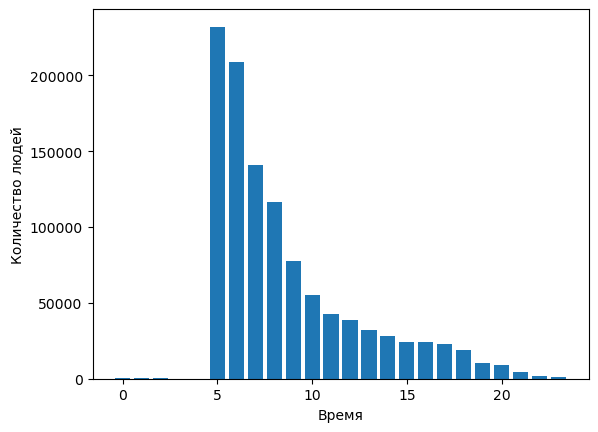

In [10]:
unique_hours = dataframe_2.hour.unique()
n_hours = dataframe_2['hour'].value_counts()

plot.figure()
plot.bar(unique_hours, n_hours)
plot.xlabel('Время')
plot.ylabel('Количество людей')

Утром люди чаще всего пользуются метро

### Повторю
train_test_split - разбивает датасет на данные для обучения и тестирования; GridSearchCV находит наилучшие параметры, путем обычного перебора

In [12]:
train_2, test_2, y_train_2, y_test_2 = train_test_split(dataframe_2.drop(['time_to_under'], axis = 1), 
                                                        dataframe_2['time_to_under'], test_size = 0.3, random_state = 34)
parametrs_2 = ['ticket_type_nm', 'station_nm', 'line_nm', 'workday']
cat_model_2 = CatBoostRegressor(iterations = 200,
                          learning_rate = 0.1,
                          cat_features = parametrs_2,
                          l2_leaf_reg = 0.01,
                          random_strength = 0.3,
                          depth = 16)
cat_model_2.fit(train_2, y_train_2)

0:	learn: 221.2424781	total: 3.05s	remaining: 10m 6s
1:	learn: 211.4030683	total: 5.21s	remaining: 8m 35s
2:	learn: 203.0740400	total: 7.52s	remaining: 8m 14s
3:	learn: 196.0610523	total: 10.2s	remaining: 8m 19s
4:	learn: 190.1750354	total: 12.7s	remaining: 8m 14s
5:	learn: 185.2745631	total: 15.2s	remaining: 8m 12s
6:	learn: 181.1928923	total: 17.8s	remaining: 8m 11s
7:	learn: 177.8145161	total: 20.3s	remaining: 8m 7s
8:	learn: 175.0199878	total: 22.8s	remaining: 8m 3s
9:	learn: 172.7073722	total: 25.1s	remaining: 7m 56s
10:	learn: 170.7806661	total: 27.6s	remaining: 7m 54s
11:	learn: 169.2016437	total: 30.3s	remaining: 7m 55s
12:	learn: 167.9102341	total: 32.7s	remaining: 7m 50s
13:	learn: 166.7943204	total: 35.4s	remaining: 7m 50s
14:	learn: 165.8491125	total: 37.5s	remaining: 7m 42s
15:	learn: 165.0788401	total: 39.9s	remaining: 7m 38s
16:	learn: 164.4351613	total: 42.2s	remaining: 7m 34s
17:	learn: 163.8814644	total: 44.7s	remaining: 7m 32s
18:	learn: 163.4099436	total: 47.1s	rema

150:	learn: 154.7474454	total: 6m 13s	remaining: 2m 1s
151:	learn: 154.6873129	total: 6m 15s	remaining: 1m 58s
152:	learn: 154.6527413	total: 6m 18s	remaining: 1m 56s
153:	learn: 154.6125797	total: 6m 20s	remaining: 1m 53s
154:	learn: 154.5926038	total: 6m 23s	remaining: 1m 51s
155:	learn: 154.5706956	total: 6m 26s	remaining: 1m 49s
156:	learn: 154.5515949	total: 6m 29s	remaining: 1m 46s
157:	learn: 154.5320438	total: 6m 31s	remaining: 1m 44s
158:	learn: 154.4802908	total: 6m 34s	remaining: 1m 41s
159:	learn: 154.4363541	total: 6m 37s	remaining: 1m 39s
160:	learn: 154.3966560	total: 6m 40s	remaining: 1m 36s
161:	learn: 154.3470733	total: 6m 42s	remaining: 1m 34s
162:	learn: 154.3113721	total: 6m 45s	remaining: 1m 31s
163:	learn: 154.2785941	total: 6m 47s	remaining: 1m 29s
164:	learn: 154.2255090	total: 6m 50s	remaining: 1m 27s
165:	learn: 154.1612656	total: 6m 52s	remaining: 1m 24s
166:	learn: 154.1486370	total: 6m 55s	remaining: 1m 22s
167:	learn: 154.1231641	total: 6m 57s	remaining: 

In [14]:
predict_2 = cat_model_2.predict(test_2)
r2_score(y_test_2, predict_2)

0.5143925864522081

### Ответ:

In [33]:
R2 = r2_score(y_test_2, predict_2)
recall = recall_score(y_test, predict, average = 'micro')
(recall + R2)/2

0.286696293226104